# Vision Transformer Use-Case

In diesem Jupyterlab-notebook wird gezeigt wie der Code zu dem Vision Transformer Paper [An Image is Worth 16x16 Words: Transformer for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929.pdf) erstellt und auf einen neuen Datensatz trainiert und angewandt wird. Der Datensatz hierfür ist der [WOD: Web Object Dataset](https://www.acin.tuwien.ac.at/vision-for-robotics/software-tools/autonomous-robot-indoor-dataset/). Dieses Jupyterlab ist eine überarbeitete Form von [GitHub Repository von mrdbourke](https://github.com/mrdbourke/pytorch-deep-learning), welcher ein frei zugängliches PyTorch Tutorial auf seiner [Homepage](https://www.learnpytorch.io/) bereitstellt.

## 0. Imports

Zuerst werden die nötigen Libraries für diesen Code importiert. Ein Teil davon: data_setup, engine, download_data, set_seeds, plot_loss_curve kommt von einem externen [GitHub Repository](https://github.com/mrdbourke/pytorch-deep-learning).

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
    
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] torchinfo konnte nicht gefunden werden ...installeieren über pip.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print("[INFO] going_modular oder helper_functions konnten nicht gefunden werden ...herunterladen von GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com, https://download.pytorch.org/whl/cu113
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/8c/67/fcc9b9e2369a9bae4da492aedc0c2dfa95d563ef0eaa9228b70c98395ec2/torch-2.2.0-cp310-cp310-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/d8/51/55393d57c2d95311b1675c8cd37d307f5022460cf98746e4df882dfb415c/torchvision-0.17.0-cp310-cp310-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for torchaudio from https://files.pythonhosted.org/packages/30/fc/cdcf7c2071539ea147ddb6de2b538d9c1599665b621f2e6cf0b3ef51d20d/torchaudio-2.2.0-cp310-cp310-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.8.0 from https://files.pythonhosted.org/packages/b7/f4/6a90020cd2d93349b442bfcb657d0dc91

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup für geräteunabhänigen Code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
image_path = "/data"
# Holen des Datensatzes von von GitHub

!wget https://cloud.technikum-wien.at/s/y2a4NkZm4TdxKRy/download -LO web_object_dataset.tar

--2024-01-30 17:37:12--  https://cloud.technikum-wien.at/s/y2a4NkZm4TdxKRy/download
Resolving cloud.technikum-wien.at (cloud.technikum-wien.at)... 172.31.251.28, 2001:67c:1790:6451::1c
Connecting to cloud.technikum-wien.at (cloud.technikum-wien.at)|172.31.251.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 575695360 (549M) [application/x-tar]
Saving to: ‘web_object_dataset.tar’

web_object_dataset. 100%[===================>] 549.03M  53.0MB/s    in 11s     

2024-01-30 17:37:22 (52.2 MB/s) - ‘web_object_dataset.tar’ saved [575695360/575695360]



In [4]:
import zipfile
import shutil

# auspacken des Datensatzes
shutil.unpack_archive("web_object_dataset.tar", "./data")

In [5]:
# löschen der .tar Datei
!rm -r web_object_dataset.tar
!rm -r ./data/washington_web/washington_web.txt

In [6]:
# erstellen eines Test und Train Aufteilung/Splits der Daten

dataset = torchvision.datasets.ImageFolder("./data/washington_web")


In [7]:
# unnötige python checkpoints löschen um Errors zu vermeiden
!rm -rf `find -type d -name .ipynb_checkpoints`

In [8]:
import os
from sklearn.model_selection import train_test_split
import shutil

# Pfade zu deinen Daten
data_directory = "./data/washington_web"
train_directory = "./data/train"
test_directory = "./data/test"

# Liste aller Klassen im Datensatz
classes = os.listdir(data_directory)

# Erstelle Train- und Testverzeichnisse
os.makedirs(train_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)

train_images_count = 0
test_images_count = 0

# Gehe durch jede Klasse und teile die Daten auf
for class_name in classes:
    images_directory = os.path.join(data_directory, class_name)
    images = os.listdir(images_directory)
    
    # Reduziere den Datensatz um 90% da ansonsten zu viel overhead für unsere bregernzte Hardware
    reduced_images, _ = train_test_split(images, test_size=0.9, random_state=42)
    
    # Aufteilen der reduzierten Bilder in Train und Test
    train_images, test_images = train_test_split(reduced_images, test_size=0.1, random_state=42)
    
    # Erstellen der Ordnerstruktur für Train
    train_class_directory = os.path.join(train_directory, class_name)
    os.makedirs(train_class_directory, exist_ok=True)
    for image in train_images:
        src = os.path.join(images_directory, image)
        dest = os.path.join(train_class_directory, image)
        shutil.copy(src, dest)
        train_images_count = train_images_count + 1
    
    # Erstellen der Ordnerstruktur für Test
    test_class_directory = os.path.join(test_directory, class_name)
    os.makedirs(test_class_directory, exist_ok=True)
    for image in test_images:
        src = os.path.join(images_directory, image)
        dest = os.path.join(test_class_directory, image)
        shutil.copy(src, dest)
        test_images_count = test_images_count + 1
        
print(f"Anzahl der Trainingsbilder: {train_images_count}, Anzahl der Testbilder: {test_images_count}, Anzahl der Klassen: {len(classes)} ")

Anzahl der Trainingsbilder: 4506, Anzahl der Testbilder: 526, Anzahl der Klassen: 51 


In [9]:
# Erzeugung von Datensätzen und Dataloader
from torchvision import transforms
from going_modular.going_modular import data_setup

# Festlegen der Bild größe
IMG_SIZE = 224  # entnommes aus Tabelle 3 vom VIT Paper

# erzeugen der Tansform Pipeline
manual_transforms = transforms.Compose([
                                        transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                        transforms.ToTensor()
])

print(f"manuell erstellte transformation: {manual_transforms}")

manuell erstellte transformation: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [10]:
train_dir = "./data/train"
test_dir = "./data/train"

In [11]:
# Definition der Batch Size von 32  (Das Paper nutzt 4096 dies ist jedoch zu viel für unsere "handelsübliche" Hardware)
BATCH_SIZE = 32

# erzeugung der Dataloader
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)
# checking
len(train_dataloader), len(test_dataloader), class_names, len(class_names)

(141,
 141,
 ['apple',
  'ball',
  'banana',
  'bell_pepper',
  'binder',
  'bowl',
  'calculator',
  'camera',
  'cap',
  'cell_phone',
  'cereal_box',
  'coffee_mug',
  'comb',
  'dry_battery',
  'flashlight',
  'food_bag',
  'food_box',
  'food_can',
  'food_cup',
  'food_jar',
  'garlic',
  'glue_stick',
  'greens',
  'hand_towel',
  'instant_noodles',
  'keyboard',
  'kleenex',
  'lemon',
  'lightbulb',
  'lime',
  'marker',
  'mushroom',
  'notebook',
  'onion',
  'orange',
  'peach',
  'pear',
  'pitcher',
  'plate',
  'pliers',
  'potato',
  'rubber_eraser',
  'scissors',
  'shampoo',
  'soda_can',
  'sponge',
  'stapler',
  'tomato',
  'toothbrush',
  'toothpaste',
  'water_bottle'],
 51)

In [12]:
## Visualisieren eines einzelnen Bildes

# holen einer Batch voller images
image_batch, label_batch = next(iter(train_dataloader))

# holen eines einzlenen Bildes & Label vom Batch
image, label = image_batch[0], label_batch[0]

# anzeigen der Batch For
image.shape, label

(torch.Size([3, 224, 224]), tensor(25))

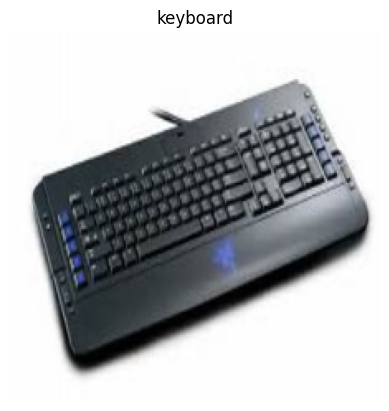

In [13]:
# ploten des Bildes mit matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0)) # (color_chan, height, widht) -> (height, width, color_chan)
plt.title(class_names[label])
plt.axis(False);

## Replizierung ViT: Übersicht



Ein ganzes Research-Paper über maschinelles Lernen zu lesen, kann sehr abschreckend sein.
Um es verständlicher zu gestalten, teilen wir es in kleinere Teile auf:

* **Inputs** -  Was geht in das Modell rein? (in unserem Fall, Bild-Tensoren)
* **Outputs** - Was kommt bei dem Modell heraus? (in unserem Fall wollen wir ein Modell, das Bildklassifizierungen ausgibt)
* **Layers** - Nimmt eine Eingangsinformation auf und manipuliert sie mit einer Funktion (z.B. self-attention).
* **Blocks** -Eine Sammlung von Schichten die Datentransformationen durchführen.
* **Model or architecture** - Eine Sammlung von Blöcken.

### ViT Übersicht: Teile des Originalpapers

* Abbildung 1: Visuelle Übersicht der Modellarchitektur
* Vier Gleichungen: mathematische Gleichungen, welche die Funktion von jeder Schicht und Block definieren
* Tabelle 1/3: verschiedene Hyperparameter für die Arichtektur des Modells  bzw. für den Trainingsprozess
* Textueller beschreibender Inhalt


#### Pseudo code, ersten Gleichung:
```python
x_input =  [class_token, image_patch_1, image_patch_2, ..., image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ..., image_patch_N_pos]
```

#### Pseudo code, zweite Gleichung:
```python
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```

#### Pseudo code, dritte Gleichung:
```python
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

* MLP = multilayer perception = ein neuronales Netz mit Anzahl X Schichten
* MLP = eine versteckte Schicht beim Training
* MLP = ein einzelner lineare Schicht beim fine tunen

#### Pseudo code, vierte Gleichung:

```python
y_output = Linear_layer(LN_layer(x_output_MLP_block))
```

* ViT-Base, ViT-Large und ViT-Huge sind alles die selben Modellarchitekturen mit verschiedenen Größen (Anzahl von Parametern)
* Layers (Lx): Anzahl von transformer encoder Blöcken/Layers  
* Hidden size $D$ - die Einbettungsgröße über die gesamten Modellarchitektur (wenn D = 768 -> jedes patch hat eine Größe von 768 => 16x16)
* MLP size - die Anzahl der versteckten Einheiten in unserer MLP
* Head - die Anzahl der multi-head self-attention Blöcken


## Gleichung 1: Aufteilen der Daten in Patches und erzeugung des Klassen Tokens sowie der Patch Embeddings

Schichten = Eingabe -> Funktion() -> Ausgabe

Was ist unsere Eingabe Form?

Was ist unsere Ausgabe Form?

*Eingabe Form:  $H\times{W}\times{C}$ (Höhe x Breite x Farbkanäle)

*Ausgabe Form: ${N \times\left(P^{2} \cdot C\right)}$

* H = Höhe

* W = Breite

* C = Farbkanäle (RGB = 3, Schwarz-Weiß = 1)

* P = Patch Größe

* N = Anzahl der Patches = (Höhe * Breite) / P^2

* D = konstante Größe des latenten Vektors = Einbettungs (embedding) Dimension (Table 1)

In [14]:
# Erzeugung von Beispielswerten
height = 224
width = 224
color_channels = 3
patch_size = 16

# Berechnung der Number of patches und Ausgabe
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [15]:
# Eingabe Form
embedding_layer_input_shape = (height, width, color_channels)

# Ausgabe Form
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


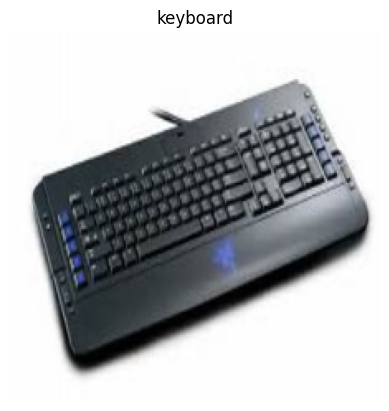

In [16]:
# Anzeigen eines einzelnen Bildes
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [17]:
# Bild als Tensor anzeigen
image

tensor([[[0.9961, 0.9961, 0.9961,  ..., 0.9922, 0.9922, 0.9922],
         [0.9961, 0.9961, 0.9961,  ..., 0.9922, 0.9922, 0.9922],
         [0.9961, 0.9961, 0.9961,  ..., 0.9922, 0.9922, 0.9922],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922]],

        [[0.9961, 0.9961, 0.9961,  ..., 0.9922, 0.9922, 0.9922],
         [0.9961, 0.9961, 0.9961,  ..., 0.9922, 0.9922, 0.9922],
         [0.9961, 0.9961, 0.9961,  ..., 0.9922, 0.9922, 0.9922],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922]],

        [[0.9961, 0.9961, 0.9961,  ..., 0.9922, 0.9922, 0.9922],
         [0.9961, 0.9961, 0.9961,  ..., 0.9922, 0.9922, 0.9922],
         [0.9961, 0.9961, 0.9961,  ..., 0.9922, 0.9922, 0.

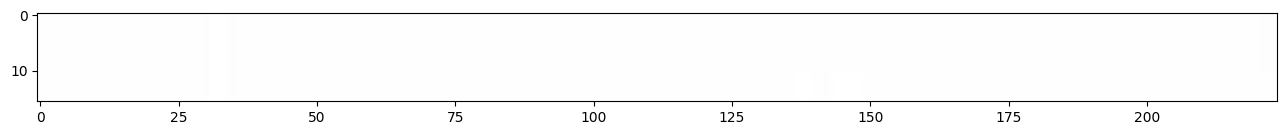

In [18]:
# wir nehmen die oberste Reihe des Bildes
image_permuted = image.permute(1,2,0)  # convert image to color channels last (H,W,C)

# Anhängen einer Indexierung
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, : ,:])

Number of patches per row: 14.0
Patch_size: 16 pixels x 16 pixels


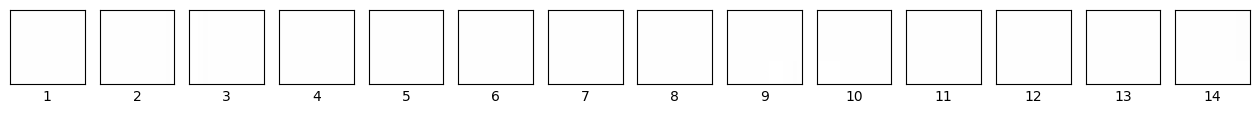

In [19]:
# Code um die oberste Reihe als Patches darzustellen
img_size =  224
patch_size = 16
num_patches = img_size/patch_size

assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch_size: {patch_size} pixels x {patch_size} pixels")

# erzeugung einer Serie von Subplots
fig, axs = plt.subplots(nrows = 1,
                        ncols = img_size // patch_size,  # one column for each patch
                        sharex = True,
                        sharey = True,
                        figsize=(patch_size, patch_size))

# Iteration durch die Anzahl der Patches in der obersten Zeile
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row 14.0      
Number of patches per column: 14.0      
Total patches: 196.0      
Patch size: 16 pixels x 16 pixels


Text(0.5, 0.98, 'keyboard -> Patchified')

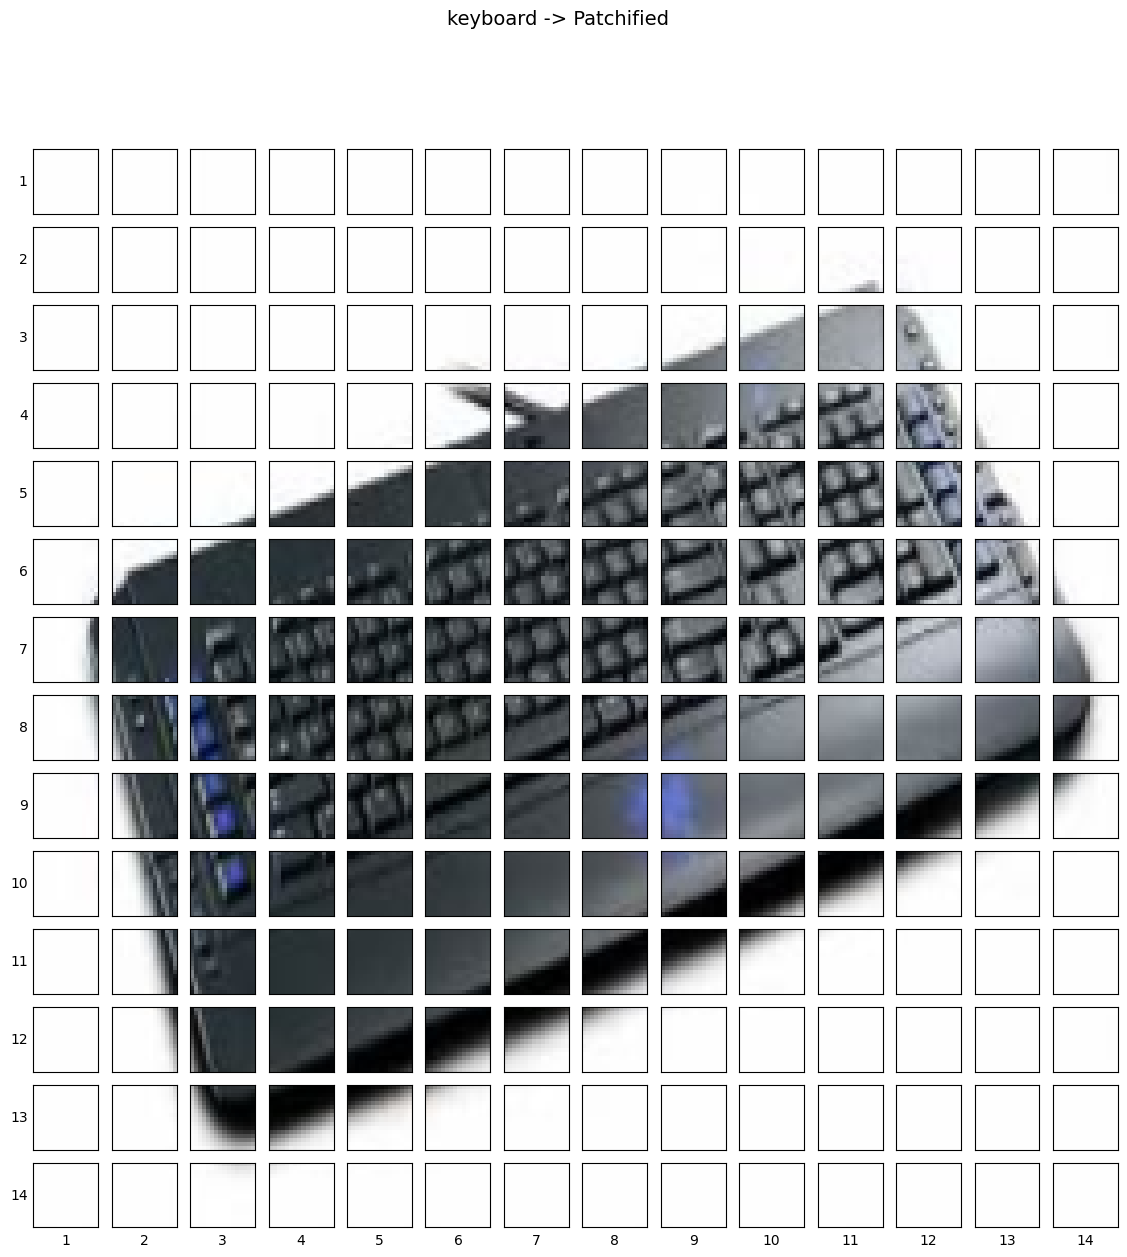

In [20]:
# Code um das ganze Bild als Patches anzuzeigen
img_size =  224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must devisible by patch size"
print(f"Number of patches per row {num_patches}\
      \nNumber of patches per column: {num_patches}\
      \nTotal patches: {num_patches*num_patches}\
      \nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows = img_size // patch_size,
                        ncols = img_size // patch_size,
                        figsize = (num_patches, num_patches),
                        sharex = True,
                        sharey = True)

# Iterieren durch die hähe und breite eines Bildes
for i , patch_height in enumerate(range(0, img_size, patch_size)): # iterieren durch höhe
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # plot permuted image on different axes
    axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterieren durch höhe
                                   patch_width:patch_width+patch_size,   # iterieren durch breite
                                   :])  # alle color channels
    
    # Einrichten von Beschriftungsinformationen für jede Teilfläche (Patch)
    axs[i,j].set_ylabel(i+1,
                        rotation="horizontal",
                        horizontalalignment="right",
                        verticalalignment="center")
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()

# Titel für Plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize = 14)

In [21]:
## Erzeugen von Bild Patches und transformieren in Einbettungen
# wir nutzen hierfür torch.nn.Conv2d() und setzen die Kernel Größe sowie Stride auf die Patchgröße
# Erzeugnung einer conv2d Schicht um das Bild in Patches von learnbaren feature-maps (Einbettungen) zu transferieren
from torch import nn

# Setzen der Patchgröße
patch_size = 16

# erzeugung einer conv2d schicht mit Hyperparameter vom ViT Paper
conv2d = nn.Conv2d(in_channels = 3,     # für Farbbilder
                    out_channels = 768,  # D size von Tablle 1 für ViT-Base
                    kernel_size = patch_size,
                    stride = patch_size,
                    padding = 0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

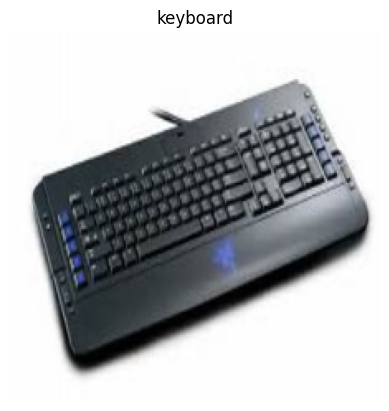

In [22]:
# Anzeigen eines einzelnen Bildes
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [23]:
# Das Bild durch die convolutional Schicht schicken  
image_out_of_conv = conv2d(image.unsqueeze(0))  # hinzufügen einer batch Dimension -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [445, 170, 123, 610, 692]


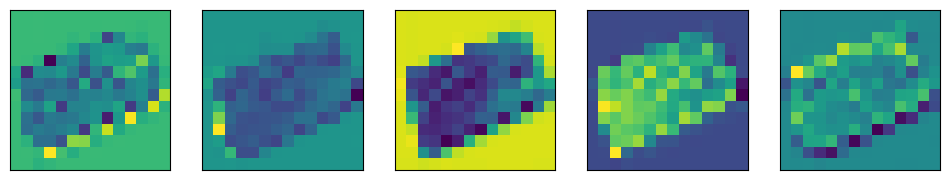

In [24]:
# plotten von zufälligen convolutional feature-maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k = 5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# erzeugung eines Plots
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize=(12,12))

# plot zufällige feature maps eines Bildes
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the ouput tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) #remove batch dimension, remove from grad tracking / switch to numpy for matplotlib
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [25]:
# anzeigen einer einzelnen feature-map in Tensorform
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[0.8887, 0.8906, 0.8900, 0.8887, 0.8887, 0.8887, 0.8887, 0.8887,
           0.8890, 0.8895, 0.8887, 0.8887, 0.8887, 0.8872],
          [0.8887, 0.8906, 0.8900, 0.8887, 0.8887, 0.8887, 0.8887, 0.8887,
           0.8885, 0.8889, 0.8325, 0.8882, 0.8887, 0.8887],
          [0.8887, 0.8906, 0.8900, 0.8887, 0.8887, 0.8718, 0.8839, 0.8833,
           0.7604, 0.6975, 0.5839, 0.7312, 0.8887, 0.8870],
          [0.8887, 0.8888, 0.8884, 0.8884, 0.8837, 0.5461, 0.4870, 0.4314,
           0.3742, 0.4195, 0.4322, 0.6575, 0.8502, 0.8886],
          [0.8883, 0.8910, 0.8053, 0.6871, 0.4437, 0.2408, 0.2347, 0.3391,
           0.3011, 0.2323, 0.3510, 0.5136, 0.8923, 0.8877],
          [0.8682, 0.7374, 0.2384, 0.1683, 0.2185, 0.2457, 0.1167, 0.1423,
           0.2301, 0.3665, 0.5063, 0.6245, 0.5868, 0.8308],
          [0.5859, 0.2143, 0.2445, 0.2046, 0.0925, 0.0903, 0.3099, 0.1604,
           0.2330, 0.3426, 0.5129, 0.6120, 0.5665, 0.8003],
          [0.7723, 0.3444, 0.2906, 0.1461, 0.1728, 0.18

In [26]:
## Flatten der Patch embedding with torch.nn.Flatten()
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


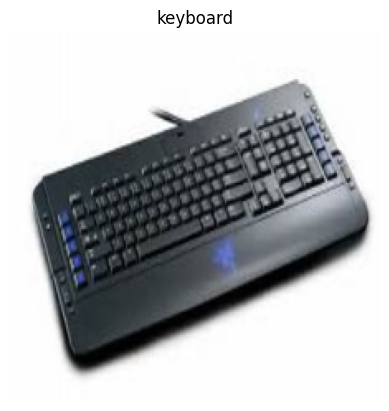

In [27]:
## Alles zusammenfügen
# Bild anzeigen
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Transformieren eines Bildes in feature-maps
image_out_if_conv = conv2d(image.unsqueeze(0)) #add bachdim
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# flatten der feature-maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [28]:
# Ausgabe der geflattenden Schicht neu anordnen
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)

print(f"{image_out_of_conv_flattened.permute(0,2,1).shape} -> (batch_size, number_of_patches, embedding_dims)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dims)


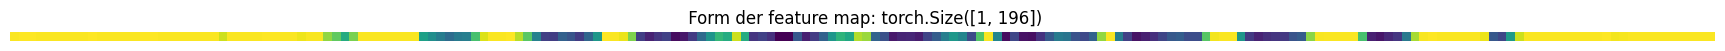

In [29]:
# Verwenden einer einzelnen gefalttende feature-map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:,  :, 0]
single_flattened_feature_map

# anzeigen der geflattenden feature-map
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f" Form der feature map: {single_flattened_feature_map.shape}")
plt.axis(False);

### Transferieren der ViT Patch Embeddings in ein PyTorch Modul.

Wir wollen das dieses Modul folgende Dinge macht:
1. Erstellen einer Klasse namens `PatchEmbedding`, die von `nn.Module` erbt.
2. Initialisierung mit geeigneten Hyperparametern, wie Kanäle, Embeddingdimension, Patchgröße.
3. Erstellen einer Schicht zur Umwandlung eines Bildes in Patch-Embeddings unter Verwendung von `nn.Conv2d()`.
4. Erstellen einer Schicht, um die feature-maps der Ausgabe von Schicht in 3.) zu flatten.
5. Definieren einer `forward()` Funktion, die das Vorwärtsberechnung definiert
6. Vergewissern, dass die Ausgabeform der Schicht die erforderliche Ausgabeform der Patch-Embedding widerspiegelt.

In [30]:
# Erster Schritt: erzeugung der Klasse mit dem namen PatchEmbedding
class PatchEmbedding (nn.Module):
  # Zweiter Schritt: Initilaisierung der Schicht mit den geeigneten Hyperparametern
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768): # from Table 1 for ViT-Base
    super().__init__()

    self.patch_size = patch_size

    # Dritter Schritt: erzugung einer Schicht um Bild in Patche-Embeddings zu transferieren
    self.patcher = nn.Conv2d(in_channels = in_channels,
                             out_channels = embedding_dim,
                             kernel_size = patch_size,
                             stride = patch_size,
                             padding = 0)

    # vierter Schritt: Erzeugung einer Schicht um die feateure-maps (Output von Conv2d) zu flatten
    self.flatten = nn.Flatten(start_dim = 2,
                              end_dim = 3)

  # Fünfter Schritt: Vorwärtsmethode definieren, um die Schritte der Vorwärtsberechnung festzulegen
  def forward(self, x):
    # Assertion erstellen, um zu prüfen, ob die Eingaben die richtige Form haben
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    # Den Vorwärtspass ausführen
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # Sechster Schritt: Sicherstellen, dass die zurückgegebenen Sequenzeinbettungsdimensionen in der richtigen Reihenfolge sind (batch_size, number_of_patches, embedding)
    return x_flattened.permute(0,2,1)


In [31]:
set_seeds()

# Erzeugung einer Instanz von Patch-Einbettungsschicht
patchify = PatchEmbedding(in_channels = 3,
                          patch_size = 16,
                          embedding_dim = 768)

# ein einzelnes Bild durch die Patch-Einbettungsschicht schicken 
print(f"Eingangsgröße des Bildes: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # extra Dimension hinzufügen
print(f"Ausgangsform der eingebetteten Patchsequenz: {patch_embedded_image.shape}")

Eingangsgröße des Bildes: torch.Size([1, 3, 224, 224])
Ausgangsform der eingebetteten Patchsequenz: torch.Size([1, 196, 768])


In [32]:
# Anzeigen des Outputs als Tensor
rand_image_tensor = torch.randn(1, 3, 224, 224)

patchify(rand_image_tensor)

tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
         [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
         [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
         ...,
         [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
         [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
         [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
       grad_fn=<PermuteBackward0>)

### Erzeugen der Klassen Embeddings

Wir wollen: ein lernbaren Klassen Token an den Anfang der Patchembeddings anhängen.

In [33]:
# Form anzeigen
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [34]:
# Batchgröße und Embedding Dimension anzeigen
batch_size  = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [35]:
# Erzeugen eines Klassen-Token-Embeddings als lernbarer Parameter, der die selbe Größe wie die Einbettungsdimension (D) hat. 
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad = True)
class_token.shape

torch.Size([1, 1, 768])

In [36]:
# Hinzufügen des Klassen Tokens an den Anfang des Patch Embeddings
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                       dim = 1) # number of patches dimensi

print(patch_embedded_image_with_class_embedding)
print(f"Sequenz von Patch-Einbettungen mit vorangestelltem Klassen-Token Form: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_tokens + number_of_patches, emedding_dims)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-1.0345,  0.2832, -0.2892,  ...,  0.7885, -0.4684,  0.3648],
         [-1.0357,  0.2834, -0.2899,  ...,  0.7883, -0.4682,  0.3647],
         ...,
         [-1.0341,  0.2834, -0.2891,  ...,  0.7888, -0.4684,  0.3647],
         [-1.0335,  0.2829, -0.2880,  ...,  0.7887, -0.4687,  0.3647],
         [-1.0335,  0.2829, -0.2880,  ...,  0.7887, -0.4687,  0.3647]]],
       grad_fn=<CatBackward0>)
Sequenz von Patch-Einbettungen mit vorangestelltem Klassen-Token Form: torch.Size([1, 197, 768]) -> (batch_size, class_tokens + number_of_patches, emedding_dims)


### Erzeugen des Positionstoken Embedding

wir wollen: eine Serie von 1 Dimensionalen lernbaren Positions Embeddings erstellen und diese an die Sequenz von Patch Embeddings anhängen.


In [37]:
# anzeigen der Sequenz von Patch Embeddings mit dem angehängten Klassen Token
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-1.0345,  0.2832, -0.2892,  ...,  0.7885, -0.4684,  0.3648],
          [-1.0357,  0.2834, -0.2899,  ...,  0.7883, -0.4682,  0.3647],
          ...,
          [-1.0341,  0.2834, -0.2891,  ...,  0.7888, -0.4684,  0.3647],
          [-1.0335,  0.2829, -0.2880,  ...,  0.7887, -0.4687,  0.3647],
          [-1.0335,  0.2829, -0.2880,  ...,  0.7887, -0.4687,  0.3647]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [38]:
# Berechnung von N (anzahl der patches)
number_of_patches = int((height*width)/ patch_size**2)

# embedding dimension abgreifen
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# erzeugung des lernbaren 1 Dimensionalen Positions Embeddings
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad = True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [39]:
# Den Positions Embedding an das Patch und den Klassentoken hinzufügen
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding

print(f"Patch und Positions Embedding Form: {patch_and_position_embedding}")
print(patch_and_position_embedding.shape)

Patch und Positions Embedding Form: tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
         [-0.0345,  1.2832,  0.7108,  ...,  1.7885,  0.5316,  1.3648],
         [-0.0357,  1.2834,  0.7101,  ...,  1.7883,  0.5318,  1.3647],
         ...,
         [-0.0341,  1.2834,  0.7109,  ...,  1.7888,  0.5316,  1.3647],
         [-0.0335,  1.2829,  0.7120,  ...,  1.7887,  0.5313,  1.3647],
         [-0.0335,  1.2829,  0.7120,  ...,  1.7887,  0.5313,  1.3647]]],
       grad_fn=<AddBackward0>)
torch.Size([1, 197, 768])


## Alles zusammenfügen: vom Bild bis zum Embedding (Gleichung 1)

In [40]:
# festlegen des seeds
set_seeds()

# 1. festlegen der patchgröße
patch_size = 16

# 2. ausgeben der Form des originalen Bildes und ermitteln der Bilddimensionen
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. den Bildtensor abfragen und eine Batchdimension hinzufügen
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. erzeugung eines Patch-Einbettungsschicht
patch_embedding_layer = PatchEmbedding(in_channels = 3,
                                       patch_size = patch_size,
                                       embedding_dim = 768)

# 5. Eingabe durch PatchEmbedding schicken
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Erzeugen der Klassen Token Einbettung
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]       # -1 -> letzte Dimension
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad = True) # versichern dass es "lernbar" ist
print(f"Class token embedding shape: {class_token.shape}")

# 7. anhängen des Klassen Tokens an die Patch Einbettung
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim = 1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Erzeugung des Positional Embeddings/Tokens
number_of_patches = int((height*width / patch_size**2))
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad = True)

# 9. Hinzufügen der Positions Einbettung an das Patch embedding mit Klassen Token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Gleichung 2: Multihead Self-Attention (MSA block)

* Multihead self-attention: welcher Teil einer Sequenz die meiste Aufmerksamkeit auf sich ziehen sollte
 * In unserem Fall haben wir eine Reihe von eingebetteten Bildfeldern, die in signifikantem Zusammenhang mit einem anderen Feld stehen.
 * Wir wollen, dass unser neuronales Netz (ViT) diese Beziehung/Darstellung lernt.
* Um MSA in PyTorch zu replizieren, können wir https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html verwenden.
* LayerNorm = Die Ebenennormalisierung (LayerNorm) ist eine Technik zur Normalisierung der Verteilungen von Zwischenschichten. Sie ermöglicht glattere Gradienten, schnelleres Training und eine bessere Generalisierungsgenauigkeit.
 * Normalization = Sorgt dafür, dass alle Daten den gleichen Mittelwert und die gleiche Standardabweichung haben.
 * In pytorch https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html, normalisiert die Werte über $D$ dimension, in unserem Fall ist $D$ Dimension die Embedding Dimension.
   * Wenn wir entlang der Embeddingdimension normalisieren, ist das so, als würden wir alle Stufen einer Treppe gleich groß machen.

In [41]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """ Erzeugt einen multi-head self-attention block ("MSA block").
  """
  def __init__(self,
               embedding_dim:int=768, # Versteckte Größe D (embedding dimenson) von Tabelle 1 von ViT-Base
               num_heads:int=12, # Heads from Table 1 for ViT Base
               attn_dropout:int=0):
    super().__init__()

    # erzeugen der nomralisierung Schicht (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

    # erzeugen der multihead attention Schicht (MSA)
    self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                num_heads = num_heads,
                                                dropout = attn_dropout,
                                                batch_first = True)  # (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                         key = x,
                                         value = x,
                                         need_weights = False)

    return attn_output

In [42]:
# erzeugung einer Instanzierung eines MSA Block's
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

# Die Patch und Positionsbild-Einbettungssequenz durch den MSA-Block leiten
patched_image_trough_msa_block = multihead_self_attention_block(patch_and_position_embedding)

print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_trough_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [43]:
 patch_and_position_embedding

tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
         [-0.0345,  1.2832,  0.7108,  ...,  1.7885,  0.5316,  1.3648],
         [-0.0357,  1.2834,  0.7101,  ...,  1.7883,  0.5318,  1.3647],
         ...,
         [-0.0341,  1.2834,  0.7109,  ...,  1.7888,  0.5316,  1.3647],
         [-0.0335,  1.2829,  0.7120,  ...,  1.7887,  0.5313,  1.3647],
         [-0.0335,  1.2829,  0.7120,  ...,  1.7887,  0.5313,  1.3647]]],
       grad_fn=<AddBackward0>)

In [44]:
patched_image_trough_msa_block

tensor([[[-0.2466, -0.1787,  0.0906,  ..., -0.4764,  0.8885, -0.5071],
         [-0.2482, -0.1694,  0.1007,  ..., -0.4769,  0.9030, -0.5150],
         [-0.2481, -0.1694,  0.1007,  ..., -0.4769,  0.9029, -0.5150],
         ...,
         [-0.2482, -0.1694,  0.1007,  ..., -0.4769,  0.9030, -0.5150],
         [-0.2482, -0.1694,  0.1007,  ..., -0.4769,  0.9030, -0.5150],
         [-0.2482, -0.1694,  0.1007,  ..., -0.4769,  0.9030, -0.5150]]],
       grad_fn=<TransposeBackward0>)

## Gleichung 3: Multilayer Percepton block (MLP block)

* **MLP** = Der MLP BlocK enthält zwei Schichten mit GELU-Nichtlinearität
  * MLP = ein oft verwendeter Begriff für ein Block mit einer Serie  von Schicht(en), hierbei kann es sich um mehrere oder auch nur eine einzige versteckte Schicht handeln.
  * Schichten können bedeuten: fully-connected, dense, linear, feed-forward, alles ähnliche Namen für dieselbe Sache. In PyTorch, werden sie oft als `torch.nn.Linear()` und in TensorFlow als `tf.keras.Dense()` bezeichnet.
  * Gelu in pytorch: https://pytorch.org/docs/stable/generated/torch.nn.GELU.html
  * MLP Anzahl der versteckten Einheiten = MLP Größe in Tabelle 1
* **Dropout** = Dropout wird, wenn es verwendet wird, nach jeder dichten Schicht angewandt, außer bei den qkv-Projektionen und direkt nach dem Hinzufügen von Positions- zu Patch-Einbettungen.
 * Der Wert für den dropout wird aus Tabelle 3 des Papers entnommen.

in pseudocode:

```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout

```

In [45]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()

    # erzeugen des Normalisierungs Layers (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

    # erzeugen des MLPs
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dim,
                  out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = dropout),
        nn.Linear(in_features = mlp_size,
                  out_features = embedding_dim),
        nn.Dropout(p = dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x
    # return self.mlp(self.layer_norm(x)) // selbes wie oben in einer Zeile

In [46]:
# Erzeugen einer Instanz eines MLP Blocks
mlp_block = MLPBlock(embedding_dim = 768,
                     mlp_size = 3072,
                     dropout = 0.1)

# die Ausgabe des MSABlocks durch MLPBlock schicken
patched_image_trough_mlp_block = mlp_block(patched_image_trough_msa_block)
print(f"Input shape of MLP block: {patched_image_trough_msa_block.shape}")
print(f"Output shape of MLP block{patched_image_trough_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP blocktorch.Size([1, 197, 768])


In [47]:
patched_image_trough_msa_block

tensor([[[-0.2466, -0.1787,  0.0906,  ..., -0.4764,  0.8885, -0.5071],
         [-0.2482, -0.1694,  0.1007,  ..., -0.4769,  0.9030, -0.5150],
         [-0.2481, -0.1694,  0.1007,  ..., -0.4769,  0.9029, -0.5150],
         ...,
         [-0.2482, -0.1694,  0.1007,  ..., -0.4769,  0.9030, -0.5150],
         [-0.2482, -0.1694,  0.1007,  ..., -0.4769,  0.9030, -0.5150],
         [-0.2482, -0.1694,  0.1007,  ..., -0.4769,  0.9030, -0.5150]]],
       grad_fn=<TransposeBackward0>)

In [48]:
patched_image_trough_mlp_block

tensor([[[-0.0528, -0.0047,  0.0759,  ...,  0.0000, -0.1477,  0.1530],
         [-0.1047, -0.1072,  0.1866,  ..., -0.0406, -0.1241,  0.2038],
         [-0.0356, -0.0583,  0.1946,  ..., -0.0000, -0.1871,  0.1735],
         ...,
         [-0.2162,  0.0008,  0.1939,  ...,  0.1837, -0.1798,  0.2549],
         [-0.1546,  0.0453,  0.0000,  ...,  0.1105, -0.1750,  0.0648],
         [-0.0617, -0.0340,  0.1308,  ..., -0.0360, -0.1743,  0.1599]]],
       grad_fn=<MulBackward0>)

## Erstellen des Transformer Encoder

Der Transformer Encoder ist eine Kombination aus abwechselnden Blöcken von MSA (Gleichung 2) und MLP (Gleichung 3).

Und zwischen jedem Block gibt es "residual" Verbindungen.

* Encoder = eine Sequenz in eine lernbare Repräsentation umwandeln
* Decoder = von der erlernten Darstellung zurück zu einer Sequenz gehen
* Residual Verbindungen  = Hinzufügen von Eingaben einer oder mehrerer Schichten zu den darauffolgenden Ausgaben, was die Schaffung tieferer Netze ermöglicht (verhindert, dass die Gewichte zu klein werden)

in pseudocode:
```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] --> ...


## Erzeugen eines Transformer Encoder blocks

In [49]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768, # Hidden size D from table 1, 768 ViT-Base
               num_heads:int=12, #from table 1
               mlp_size:int=3072, #from table 1,
               mlp_dropout:int=0.1, #from table 3,
               attn_dropout:int=0):
    super().__init__()

    # create MSA block (Gleichung 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim = embedding_dim,
                                                 num_heads = num_heads,
                                                 attn_dropout = attn_dropout)

    # create MLP block (Gleichung 3)
    self.mlp_block = MLPBlock(embedding_dim = embedding_dim,
                              mlp_size = mlp_size,
                              dropout = mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x # residual/skip Verbindung für Gleichung 2
    x = self.mlp_block(x) + x # residual/skip Verbindung für Gleichung 3
    return x

In [50]:
# Erzeugung einer Instanz TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Erzeugung einer Zusammenfassung mit tochinfo.summery
summary(model = transformer_encoder_block,
        input_size = (1, 197, 768),
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings=["var_names"]) # (batch_size, num_of_patches, embedding_dim)


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

## Erzeugen eines Transformer Encoder Schicht mit eingebauten Pytorch Schichten

https://pytorch.org/docs/stable/nn.html#transformer-layers

In [51]:
# wir erzeugen das selbe wie oben mit torch.nn.TransformerEncoderLayer()

# Gleichung 2 und 3 + Encoder
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = 768, # embedding size from table 1
                                                             nhead = 12, # heads from table 1,
                                                             dim_feedforward = 3072, # MLP size from table 1
                                                             dropout = 0.1,
                                                             activation = "gelu",
                                                             batch_first = True,
                                                             norm_first = True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [52]:
# Erzeugen einer Zusammenfassung mit torchinfo.summery
summary(model = torch_transformer_encoder_layer,
        input_size = (1, 197, 768),
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings=["var_names"]) # (batch_size, num_of_patches, embedding_dim)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## Zusammenfügen um einen ViT zu erzeugen

In [53]:
# erzeugen einer ViT Klasse

class ViT(nn.Module):
  def __init__(self,
               img_size:int=224, # Tabelle 3 vom VIT Paper
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12, # Tabelle 1 "Layers" für ViT-Base
               embedding_dim:int=768, # Versteckte Größe D von Tabelle 1 für ViT-Base,
               mlp_size:int = 3072, # Tabelle 1
               num_heads:int = 12, #T Tabelle 1
               attn_dropout:int = 0,
               mlp_dropout:int = 0.1,
               embedding_dropout:int = 0.1, # Dropout für Patch- und Positionseinbettungen
               num_classes:int = 51): # Anzahl der Klassen in unserem Klassifizierungsproblem

    super().__init__()

    # eine Assertion machen, dass die Bildgröße mit der Patchgröße kompatibel ist
    assert img_size % patch_size == 0, f"Die Bildgröße muss durch die Größe des Patches teilbar sein, Bildgröße: {img_size}, patch Größe: {patch_size}"

    # Berechung der Anzahl der Patches (height * widht/patch^2)
    self.num_patches = (img_size * img_size) // patch_size ** 2

    # eine lernfähige Klasseneinbettung erstellen
    self.class_embedding = nn.Parameter(data = torch.randn(1, 1, embedding_dim),
                                        requires_grad = True)

    # lernfähige Positionseinbettung erstellen
    self.position_embedding = nn.Parameter(data = torch.randn(1, self.num_patches+1, embedding_dim))

    # Erzeugen eines Einbettung-dropout Werts
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Patch-Einbettungsschicht erstellen
    self.patch_embedding = PatchEmbedding(in_channels = in_channels,
                                          patch_size = patch_size,
                                          embedding_dim = embedding_dim)

    # erzeugen des transformer encoder Blocks
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])   # erzeugen einer Liste von 12 transformer encoder blocks,
                                                                                                                                          # Liste in eine eigene Reihe von Schichten umwandeln unter Verwendung des Stern *-Parameters

    # erzeugen des Klassifikationsblocks
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features = embedding_dim,
                  out_features = num_classes)
    )

  def forward(self, x):
    # einlesen der Batch Größe
    batch_size = x.shape[0]

    # erzeugen einer Klassen Token Einbettung und erweitert sodass es auf die Batch Größe passt (Gleichung 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" bedeutet, dass die Dimensionen abgeleitet werden.

    # erzeugen der Patch Einbettung (Gleichung 1)
    x = self.patch_embedding(x)

    # concat Klassen Token Einbettung und Patch Einbettung (Gleichung 1)
    x = torch.cat((class_token, x), dim = 1) # (batch_size, num_patches, embedding dim) in der ersten Dimension

    # hinzufügen der Positionseinbettung zu dem Klassen Token und der Patcheinbettung
    x = self.position_embedding + x

    # Dropout auf Patch-Einbettungen anwenden (direkt nach Hinzufügen von Poistional- zu Patch-Einbettungen)
    x = self.embedding_dropout(x)

    # Übergabe der Position und der Patch-Einbettung an den Transformator-Encoder (Gleichung 2 & 3)
    x = self.transformer_encoder(x)

    # Setzen des 0. Index logit durch den Classifier (Gleichung 4)
    x = self.classifier(x[:, 0]) # jede Batch und der nullte Index dort

    return x

In [54]:
set_seeds()

# Erstellen eines zufälligen Bild-Tensors mit derselben Form wie das Einzelbild
random_image_tensor = torch.randn(1, 3, 224, 224)

# eine Instanz von ViT mit der Anzahl der Klassen erstellen, mit denen wir arbeiten
vit = ViT(num_classes = 51)

# Übergeben Sie den zufälligen Bildtensor an unsere ViT-Instanz 
vit(random_image_tensor)

tensor([[-0.0068,  0.9030,  1.2888, -0.6094, -1.3436,  0.4266, -0.2128, -0.2136,
         -0.6455,  0.6282,  0.2518,  0.3854, -0.3564, -0.1742, -0.8396, -0.0899,
         -0.4551, -0.6048,  0.7055,  0.1287, -0.0646,  0.8920, -0.1082, -0.0058,
          0.5047, -0.3781,  0.5577,  0.4088, -0.3004, -0.3323,  0.0841, -0.0050,
          0.3997,  0.1207,  0.6737, -0.4875, -0.3154,  0.2380, -0.7172,  0.8528,
         -1.1755, -0.8462,  0.0623, -0.3031,  0.3047, -1.0035, -0.0441, -0.8563,
          0.3294,  0.0234, -0.6916]], grad_fn=<AddmmBackward0>)

## Visueller Überblick über unser ViT-Modell 


In [55]:
from torchinfo import summary

# mit tochinfo.summery eine Zusammenfassung erhalten 
summary(model = ViT(num_classes=len(class_names)),
        input_size = (1, 3, 224, 224),
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings=["var_names"]) # (batch_size, num_of_patches, embedding_dim)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 51]              152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## Einrichten von Trainingscode für benutzerdefinierte ViT 



### Definieren eines Optimierers (Optimizer)

In dem Paper wird der Adam Optimizer (section 4, Training & finetuning) verwendet.
Mit einem $B1$ Wert von 0.9, und $B2$ von 0.999 (defaults) sowie weight decay von 0.1

weight decay = ist eine Form der Regularisierung, bei der große Gewichte im Netzwerk bestraft werden. Dies geschieht durch Hinzufügen eines Terms zur Verlustfunktion, der proportional zur Summe der quadrierten Gewichte ist. Dieser Term reduziert die Größe der Gewichte und verhindert, dass sie zu groß werden.

regularization Technik = verhindert overfitting

### Definieren einer Verlustfunktion (Lossfunction)

In dem ViT-Paper wird nicht erwähnt, welche Verlustfunktion verwendet wurde.

Da es sich um eine Mehrklassen-Klassifikation handelt, verwenden wir die `troch.nn.CrossEntropyLoss()`.

## Training des ViT Modell's

In [56]:
from going_modular.going_modular import engine

set_seeds()

optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             betas=(0.9,0.999),
                             weight_decay=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model = vit,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       epochs = 10,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       device = device)

 10%|████████████████▋                                                                                                                                                      | 1/10 [02:10<19:37, 130.86s/it]

Epoch: 1 | train_loss: 4.0391 | train_acc: 0.0331 | test_loss: 3.8951 | test_acc: 0.0578


 20%|█████████████████████████████████▍                                                                                                                                     | 2/10 [04:23<17:32, 131.62s/it]

Epoch: 2 | train_loss: 3.9114 | train_acc: 0.0499 | test_loss: 3.8928 | test_acc: 0.0388


 30%|██████████████████████████████████████████████████                                                                                                                     | 3/10 [06:34<15:19, 131.35s/it]

Epoch: 3 | train_loss: 3.8849 | train_acc: 0.0457 | test_loss: 3.8562 | test_acc: 0.0388


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                    | 4/10 [08:44<13:05, 130.87s/it]

Epoch: 4 | train_loss: 3.8646 | train_acc: 0.0457 | test_loss: 3.8610 | test_acc: 0.0578


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 5/10 [10:53<10:51, 130.36s/it]

Epoch: 5 | train_loss: 3.8509 | train_acc: 0.0500 | test_loss: 3.8316 | test_acc: 0.0578


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 6/10 [13:03<08:40, 130.06s/it]

Epoch: 6 | train_loss: 3.8340 | train_acc: 0.0491 | test_loss: 3.8215 | test_acc: 0.0578


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 7/10 [15:12<06:29, 129.81s/it]

Epoch: 7 | train_loss: 3.8277 | train_acc: 0.0550 | test_loss: 3.8117 | test_acc: 0.0578


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 8/10 [17:21<04:19, 129.63s/it]

Epoch: 8 | train_loss: 3.8230 | train_acc: 0.0532 | test_loss: 3.8079 | test_acc: 0.0578


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 9/10 [19:30<02:09, 129.48s/it]

Epoch: 9 | train_loss: 3.8182 | train_acc: 0.0555 | test_loss: 3.8104 | test_acc: 0.0578


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [21:40<00:00, 130.00s/it]

Epoch: 10 | train_loss: 3.8187 | train_acc: 0.0578 | test_loss: 3.8150 | test_acc: 0.0578


## Was unserem Trainingsaufbau fehlt

Wie unterscheidet sich unser Ausbildungskonzept von dem des ViT-Papiers?

Verhindern von underfitting:
* Daten - unser setup benutzt viel weniger Daten ( 4506 vs mehrere Millionen)

Verhindern von overfitting:
* Lernrate warmup - mit einer niedrigen Lernrate beginnen und auf eine Basis-LR erhöhen
* Lernrate decay - Wenn sich Ihr Modell der Konvergenz nähert, beginnen Sie, die Lernrate zu verringern.
* Gradienten clipping - verhindern dass die Gradienten zu groß werden

## Darstellung der Verlustkurven für unser Modell

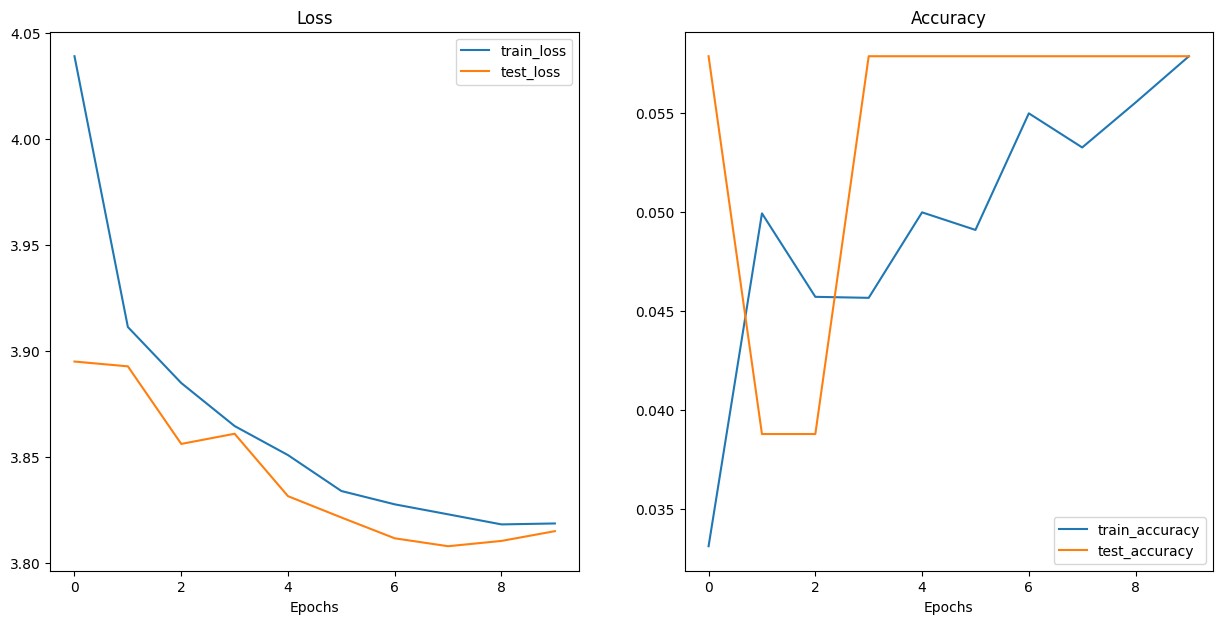

In [57]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## Verwendung eines vortrainierten ViT aus `torchvision.models`

Wenn Sie beim Deep Learning ein vortrainiertes Modell aus einem großen Datensatz für Ihr eigenes Problem verwenden können, ist das oft ein guter Ausgangspunkt.

Dies erzielt oft große Ergebnisse mit wenigen Daten

**Warum ein vortrainiertes Modell verwenden?**

* oft sind die Daten begrenzt
* begrenzte Trainingsressourcen (Hardware)
* schneller bessere Ergebnisse erzielen


In [58]:
import torch
import torchvision

In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [60]:
# vortrainierte Gewichte für ViT-Base laden
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # DEFAULT = bestes verfügbares

# eine ViT-Modellinstanz mit vortrainierten Gewichten aufzusetzen
pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_weights).to(device)

# Einfrieren der Basisparameter
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

# den Klassifizierungskopf aktualisieren
set_seeds()
pretrained_vit.heads = nn.Linear(in_features = 768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330M/330M [00:06<00:00, 55.8MB/s]


In [61]:
from torchinfo import summary

# eine Zusammenfassung mit tochinfo.summery erstellen
summary(model = pretrained_vit,
        input_size = (1, 3, 224, 224),
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings=["var_names"]) # (batch_size, num_of_patches, embedding_dim)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 51]              768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### Daten für das vortrainierte ViT Modell vorbereite 

Wenn Sie ein vorab trainiertes Modell verwenden, sollten Sie sicherstellen, dass Ihre Daten auf dieselbe Weise formatiert sind, auf die das Modell trainiert wurde.

In [62]:
# übernehmen der "Transforms" von vortarinierten ViT Gewichten

vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [63]:
train_dir, test_dir

('./data/train', './data/train')

In [64]:
# Aufstezen des dataloaders 
from going_modular.going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                                     test_dir = test_dir,
                                                                                                     transform = vit_transforms,
                                                                                                     batch_size = 32) 

### Training eines feature extractor ViT Modells

Wir nehmen nun das vortrainierte Modell und finetunen es auf unseren Datensatz.

In [65]:
from going_modular.going_modular import engine

# erstellen eines Optimierers und eine Verlustsfunktion
optimizer = torch.optim.Adam(params = pretrained_vit.parameters(),
                             lr = 1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Trainieren des Klassifikationskopf des vortrainierten ViT
set_seeds()
pretrained_vit_results = engine.train(model = pretrained_vit,
                                      train_dataloader = train_dataloader_pretrained,
                                      test_dataloader = test_dataloader_pretrained,
                                      optimizer = optimizer,
                                      loss_fn = loss_fn,
                                      epochs = 10,
                                      device = device)

 10%|████████████████▊                                                                                                                                                       | 1/10 [01:20<12:00, 80.11s/it]

Epoch: 1 | train_loss: 1.1845 | train_acc: 0.7647 | test_loss: 0.3728 | test_acc: 0.9245


 20%|█████████████████████████████████▌                                                                                                                                      | 2/10 [02:38<10:32, 79.11s/it]

Epoch: 2 | train_loss: 0.3208 | train_acc: 0.9244 | test_loss: 0.2085 | test_acc: 0.9634


 30%|██████████████████████████████████████████████████▍                                                                                                                     | 3/10 [03:56<09:11, 78.80s/it]

Epoch: 3 | train_loss: 0.2021 | train_acc: 0.9567 | test_loss: 0.1422 | test_acc: 0.9782


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 4/10 [05:15<07:52, 78.71s/it]

Epoch: 4 | train_loss: 0.1418 | train_acc: 0.9746 | test_loss: 0.1032 | test_acc: 0.9885


 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 5/10 [06:34<06:33, 78.69s/it]

Epoch: 5 | train_loss: 0.1057 | train_acc: 0.9851 | test_loss: 0.0771 | test_acc: 0.9920


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 6/10 [07:52<05:14, 78.68s/it]

Epoch: 6 | train_loss: 0.0811 | train_acc: 0.9905 | test_loss: 0.0622 | test_acc: 0.9938


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 7/10 [09:11<03:55, 78.64s/it]

Epoch: 7 | train_loss: 0.0655 | train_acc: 0.9909 | test_loss: 0.0496 | test_acc: 0.9978


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 8/10 [10:29<02:37, 78.63s/it]

Epoch: 8 | train_loss: 0.0530 | train_acc: 0.9945 | test_loss: 0.0405 | test_acc: 0.9987


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 9/10 [11:48<01:18, 78.63s/it]

Epoch: 9 | train_loss: 0.0439 | train_acc: 0.9953 | test_loss: 0.0348 | test_acc: 0.9987


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [13:07<00:00, 78.74s/it]

Epoch: 10 | train_loss: 0.0361 | train_acc: 0.9980 | test_loss: 0.0301 | test_acc: 0.9987


## Darstellung der Verlustkurven des vortrainierten ViT-Feature-Extraktor-Modells

Wie wir sehen ist das Modell durch die zuhilfenahme eines vortrainierten VIT-Modells wesentlich zuverlässiger. Dies lässt sich dadurch begründen dass das vortrainierte Modell schon gelernt hat wie gewisse Merkmale in einem Bild aussehen. Wir verwenden dieses vortrainerte Wissen und wenden es auf unseren neuen Datensatz an um eine neue Klassifikationsaufgabe zu lösen.

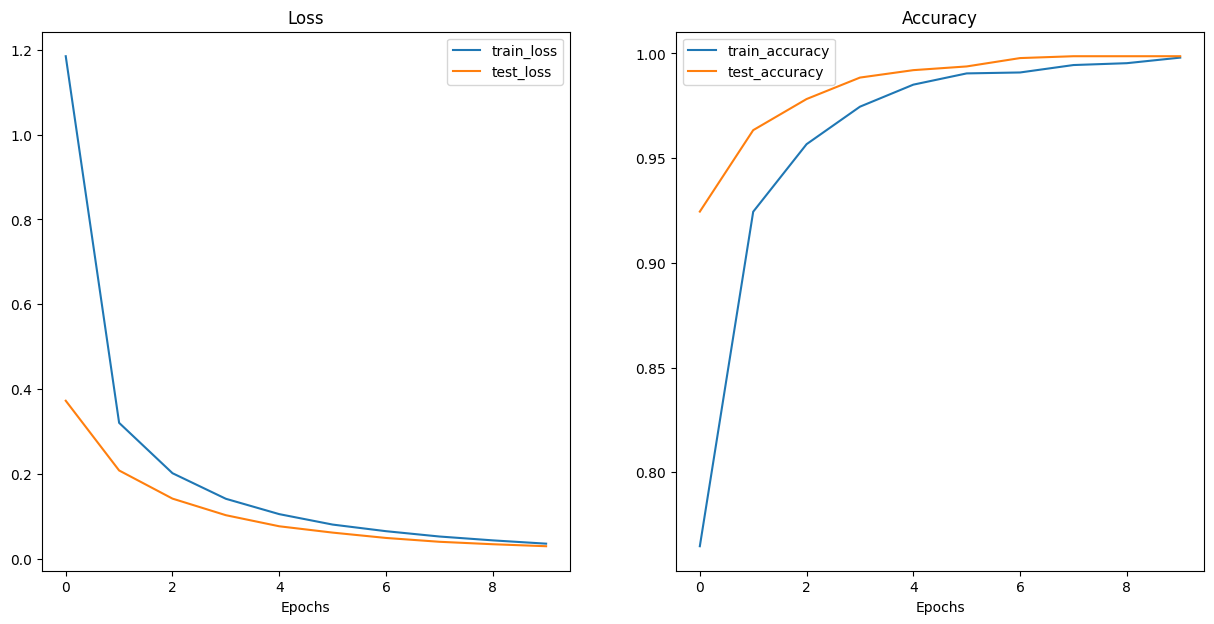

In [66]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

### Speichern des besten Modells

In [67]:
from going_modular.going_modular import utils

utils.save_model(model = pretrained_vit,
                target_dir = "models", 
                model_name = "pytorch_vit_transfer_learning_model.pth")

[INFO] Saving model to: models/pytorch_vit_transfer_learning_model.pth


In [68]:
from pathlib import Path

# auslesen der Modellgröße in Bytes und dann in Megabytes konvertieren
pretrained_vit_model_size = Path("models/pytorch_vit_transfer_learning_model.pth").stat().st_size // (1024*1024)
print(f"vortranierte ViT extractor Modellgröße: {pretrained_vit_model_size} MB")

vortranierte ViT extractor Modellgröße: 327 MB


### Vorhersage auf benutzerdefiniertem Bild treffen

Wir können nun unser Modell verwenden und versuchen beliebige Bilder zu klassifizieren:

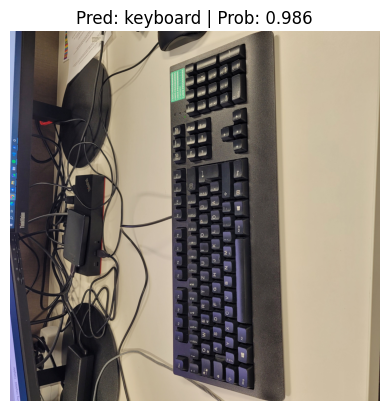

In [69]:
import requests
from PIL import Image

# Importieren der Funktionen um Vorhersagen auf ungesehene Bilder zu treffen und diese zu plotten
from going_modular.going_modular.predictions import pred_and_plot_image

# Aufsetzen des benutzerdefinierten Bildpfads 
custom_image_path = "./data/keyboard.jpg"

# Laden Sie das Bild herunter, wenn es noch nicht existiert.
with open(custom_image_path, "wb") as f:
        # Beim Herunterladen von GitHub muss der "raw"-Dateilink verwendet werden.
        request = requests.get("https://raw.githubusercontent.com/AlessandroScherl/LRP/main/keyboard.jpg")
        
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)

# Vorhersage auf benutzerdefiniertem Bild
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)